In [1]:
using Turing
using LimberJack
using CSV
using NPZ
using FITSIO
using LinearAlgebra
using PythonCall
using ForwardDiff
np = pyimport("numpy")

    CondaPkg Found dependencies: /home/jaime/.julia/environments/v1.7/CondaPkg.toml
    CondaPkg Dependencies already up to date


Python module: <module 'numpy' from '/home/jaime/.julia/environments/v1.7/.CondaPkg/env/lib/python3.11/site-packages/numpy/__init__.py'>

## T-Matrices wlwl dz

In [4]:
#println("My id is ", myid(), " and I have ", Threads.nthreads(), " threads")

fol = "DESY1"
#fol = "DESY1"
data_set = "wlwl_Nzs_40"
meta = np.load(string("../data/", fol, "/", data_set, "_meta.npz"))
files = npzread(string("../data/", fol, "/", data_set, "_files.npz"))

tracers_names = pyconvert(Vector{String}, meta["tracers"])
pairss = pyconvert(Vector{Vector{String}}, meta["pairs"]);
idx = pyconvert(Vector{Int}, meta["idx"])
data_vector = pyconvert(Vector{Float64}, meta["cls"])
cov_tot = pyconvert(Matrix{Float64}, meta["cov"])
inv_cov_tot = pyconvert(Matrix{Float64}, meta["inv_cov"])

nz_path = "../data/DESY1/binned_40_nzs/"
zs_k0, nz_k0, cov_k0 = get_nzs(nz_path, "DESwl__0_e")
zs_k1, nz_k1, cov_k1 = get_nzs(nz_path, "DESwl__1_e")
zs_k2, nz_k2, cov_k2 = get_nzs(nz_path, "DESwl__2_e")
zs_k3, nz_k3, cov_k3 = get_nzs(nz_path, "DESwl__3_e")

(Float32[0.06, 0.099999994, 0.14, 0.18, 0.22, 0.26, 0.3, 0.34, 0.38, 0.42000002  …  1.26, 1.3, 1.34, 1.38, 1.4200001, 1.46, 1.5, 1.54, 1.5799999, 1.62], [0.0009240673730447433, 0.005814852428634714, 0.0043443927624754715, 0.0041160596873804104, 0.009895392517209878, 0.003943404553941104, 0.005722829819267932, 0.0033400048064060497, 0.007211179232808158, 0.0031238118244838213  …  0.031763332972974484, 0.00911825258939116, 0.011404821613995498, 0.014876208760203333, 0.013381480231233972, 0.01378891718945615, 0.007705600228305088, 0.0036701150619442577, 0.0035936918557433503, 0.003960094429040499], [1.3836301678444849e-6 -1.3977640396582891e-8 … -1.395804086718494e-10 1.0317296311408265e-9; -1.3977640396582891e-8 2.103089987389617e-5 … -3.98300461516264e-9 -3.6854268751077994e-9; … ; -1.395804086718494e-10 -3.98300461516264e-9 … 3.774187479133305e-6 3.6353211990832475e-9; 1.0317296311408265e-9 -3.6854268751077994e-9 … 3.6353211990832475e-9 4.229474497801167e-6])

In [5]:
function model_cov(x;
               tracers_names=tracers_names,
               pairss=pairss,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.30, 0.05, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_dz" => x[1],
                     "DESwl__1_e_dz" => x[2],
                     "DESwl__2_e_dz" => x[3],
                     "DESwl__3_e_dz" => x[4],
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, tracers_names, pairss,
                  idx, files; Nuisances=nuisances)
end;

In [6]:
d = 0.00005
n_cls = 240
m  = 4
T = zeros(n_cls, m)

for i in 1:m
    dz = zeros(m)
    e = zeros(m)
    e[i] = d
    T[:, i] = (model_cov(dz.+e) .- model_cov(dz.-e)) ./ (2*d)
end

In [7]:
dz_cov = [0.017^2 0 0 0; 
          0 0.017^2 0 0;
          0 0 0.013^2 0;
          0 0 0 0.015^2] 

4×4 Matrix{Float64}:
 0.000289  0.0       0.0       0.0
 0.0       0.000289  0.0       0.0
 0.0       0.0       0.000169  0.0
 0.0       0.0       0.0       0.000225

In [8]:
TPT = T * dz_cov * T'

240×240 Matrix{Float64}:
 6.55468e-20  3.40506e-20  2.14517e-20  …  0.0          0.0
 3.40506e-20  1.76888e-20  1.11439e-20     0.0          0.0
 2.14517e-20  1.11439e-20  7.02059e-21     0.0          0.0
 1.53237e-20  7.96042e-21  5.01503e-21     0.0          0.0
 1.18035e-20  6.13175e-21  3.86298e-21     0.0          0.0
 9.58113e-21  4.97726e-21  3.13565e-21  …  0.0          0.0
 8.07121e-21  4.19288e-21  2.6415e-21      0.0          0.0
 6.94511e-21  3.60788e-21  2.27295e-21     0.0          0.0
 6.01233e-21  3.12332e-21  1.96768e-21     0.0          0.0
 5.21803e-21  2.71069e-21  1.70772e-21     0.0          0.0
 4.53737e-21  2.3571e-21   1.48496e-21  …  0.0          0.0
 3.94869e-21  2.05129e-21  1.2923e-21      0.0          0.0
 3.43389e-21  1.78386e-21  1.12382e-21     0.0          0.0
 ⋮                                      ⋱               
 0.0          0.0          0.0             1.12259e-22  9.57897e-23
 0.0          0.0          0.0             9.50676e-23  8.11207e-23
 0

In [9]:
C_mod = Symmetric(cov_tot + TPT);
inv_C_mod = inv(C_mod)

240×240 Symmetric{Float64, Matrix{Float64}}:
  1.26842e18   1.59641e17  -6.57338e15  …  -3.80427e15  -4.42146e15
  1.59641e17   2.63374e18   2.93227e17     -1.88945e15  -2.34235e15
 -6.57338e15   2.93227e17   4.01124e18     -1.50475e15  -1.95076e15
 -8.25376e15  -6.32952e15   4.35281e17     -1.2157e15   -1.66498e15
 -7.64114e15  -1.30102e16   3.22067e15     -9.42765e14  -1.39672e15
 -6.92276e15  -1.51406e16  -1.11653e16  …  -7.3416e14   -1.19537e15
 -7.0962e15   -1.6782e16   -1.77185e16     -5.8521e14   -1.0541e15
 -7.31311e15  -1.84349e16  -2.25220e16     -5.02965e14  -1.01232e15
 -8.35562e15  -2.18792e16  -2.74846e16     -4.65526e14  -1.06865e15
 -9.23584e15  -2.50829e16  -3.27665e16     -4.16613e14  -1.13205e15
 -1.04317e16  -2.87491e16  -3.78199e16  …  -3.75524e14  -1.19828e15
 -1.23194e16  -3.42842e16  -4.56467e16     -3.56869e14  -1.32153e15
 -1.41778e16  -3.9769e16   -5.32266e16     -3.44781e14  -1.45562e15
  ⋮                                     ⋱               
 -4.31429e14   

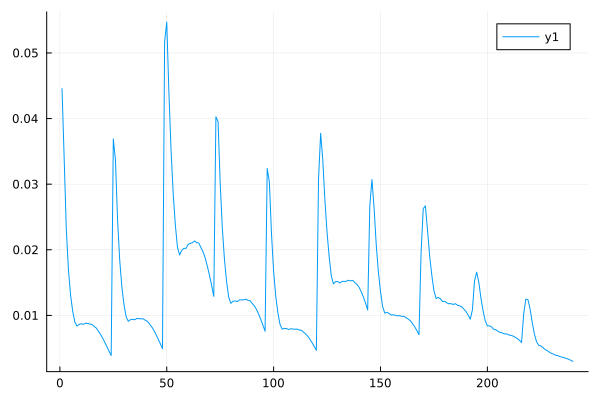

In [10]:
using Plots
plot(abs.(diag(cov_tot) .- diag(C_mod)) ./ diag(cov_tot))

In [38]:
npzwrite("../data/DESY1/binned_40_nzs/wlwl_dz_cov_marg.npz",
        Dict("TPT" => TPT,
             "cov_marg" => C_mod,
             "inv_cov_marg" => inv_C_mod))

## T-Matrices wlwl

In [113]:
#println("My id is ", myid(), " and I have ", Threads.nthreads(), " threads")

fol = "LSST"
data_set = "wlwl_Nzs_40"
meta = np.load(string("../data/", fol, "/", data_set, "_meta.npz"))
files = npzread(string("../data/", fol, "/", data_set, "_files.npz"))

tracers_names = pyconvert(Vector{String}, meta["tracers"])
pairs = pyconvert(Vector{Vector{String}}, meta["pairs"]);
idx = pyconvert(Vector{Int}, meta["idx"])
data_vector = pyconvert(Vector{Float64}, meta["cls"])
cov_tot = pyconvert(Matrix{Float64}, meta["cov"])
inv_cov_tot = pyconvert(Matrix{Float64}, meta["inv_cov"])

nz_path = "../data/DESY1/binned_40_nzs/"
zs_k0, nz_k0, cov_k0 = get_nzs(nz_path, "DESwl__0_e")
zs_k1, nz_k1, cov_k1 = get_nzs(nz_path, "DESwl__1_e")
zs_k2, nz_k2, cov_k2 = get_nzs(nz_path, "DESwl__2_e")
zs_k3, nz_k3, cov_k3 = get_nzs(nz_path, "DESwl__3_e")

(Float32[0.06, 0.099999994, 0.14, 0.18, 0.22, 0.26, 0.3, 0.34, 0.38, 0.42000002  …  1.26, 1.3, 1.34, 1.38, 1.4200001, 1.46, 1.5, 1.54, 1.5799999, 1.62], [0.0009240673730447433, 0.005814852428634714, 0.0043443927624754715, 0.0041160596873804104, 0.009895392517209878, 0.003943404553941104, 0.005722829819267932, 0.0033400048064060497, 0.007211179232808158, 0.0031238118244838213  …  0.031763332972974484, 0.00911825258939116, 0.011404821613995498, 0.014876208760203333, 0.013381480231233972, 0.01378891718945615, 0.007705600228305088, 0.0036701150619442577, 0.0035936918557433503, 0.003960094429040499], [1.3836301678444849e-6 -1.3977640396582891e-8 … -1.395804086718494e-10 1.0317296311408265e-9; -1.3977640396582891e-8 2.103089987389617e-5 … -3.98300461516264e-9 -3.6854268751077994e-9; … ; -1.395804086718494e-10 -3.98300461516264e-9 … 3.774187479133305e-6 3.6353211990832475e-9; 1.0317296311408265e-9 -3.6854268751077994e-9 … 3.6353211990832475e-9 4.229474497801167e-6])

In [110]:
println(np.average(zs_k0, weights=nz_k0))
println(np.average(zs_k1, weights=nz_k1))
println(np.average(zs_k2, weights=nz_k2))
println(np.average(zs_k3, weights=nz_k3))

0.3593318851787447
0.4909224834984977
0.7658070710228834
0.9799214358359419


In [66]:
function model_cov0(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.30, 0.05, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => x,
                     "DESwl__1_e_nz" => nz_k1,
                     "DESwl__2_e_nz" => nz_k2,
                     "DESwl__3_e_nz" => nz_k3,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov1(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.30, 0.05, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => nz_k0,
                     "DESwl__1_e_nz" => x,
                     "DESwl__2_e_nz" => nz_k2,
                     "DESwl__3_e_nz" => nz_k3,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov2(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.30, 0.05, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => nz_k0,
                     "DESwl__1_e_nz" => nz_k1,
                     "DESwl__2_e_nz" => x,
                     "DESwl__3_e_nz" => nz_k3,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov3(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.30, 0.05, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => nz_k0,
                     "DESwl__1_e_nz" => nz_k1,
                     "DESwl__2_e_nz" => nz_k2,
                     "DESwl__3_e_nz" => x,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

In [67]:
d = 0.005
n_cls = 240
m  = length(nz_k0)
println(m)
T0 = zeros(n_cls, m)
T1 = zeros(n_cls, m)
T2 = zeros(n_cls, m)
T3 = zeros(n_cls, m)

for i in 1:m
    e = zeros(m)
    e[i] = d
    T0[:, i] = (model_cov0(nz_k0.+e) .- model_cov0(nz_k0.-e)) ./ (2*d)
    T1[:, i] = (model_cov1(nz_k1.+e) .- model_cov1(nz_k1.-e)) ./ (2*d)
    T2[:, i] = (model_cov2(nz_k2.+e) .- model_cov2(nz_k2.-e)) ./ (2*d)
    T3[:, i] = (model_cov3(nz_k3.+e) .- model_cov3(nz_k3.-e)) ./ (2*d)
end

40


In [68]:
#T0 = ForwardDiff.jacobian(model_cov0, nz_k0)
#T1 = ForwardDiff.jacobian(model_cov1, nz_k1)
#T2 = ForwardDiff.jacobian(model_cov2, nz_k2)
#T3 = ForwardDiff.jacobian(model_cov3, nz_k3)

In [69]:
TT0 = T0 * cov_k0 * T0'
TT1 = T1 * cov_k1 * T1'
TT2 = T2 * cov_k2 * T2'
TT3 = T3 * cov_k3 * T3';

In [70]:
C_mod = Symmetric(cov_tot + TT0 + TT1 + TT2 + TT3);
inv_C_mod = inv(C_mod)

240×240 Symmetric{Float64, Matrix{Float64}}:
  7.75619e19  -5.96274e18  -6.13218e18  …   9.03236e17   1.11005e18
 -5.96274e18   1.55533e20  -7.52178e18      5.77894e17   7.76023e17
 -6.13218e18  -7.52178e18   2.42431e20      5.19739e17   6.68579e17
 -6.12133e18  -7.52772e18  -7.96236e18      6.01156e17   7.59987e17
 -6.09627e18  -7.48955e18  -7.94783e18      7.93426e17   9.85982e17
 -6.04098e18  -7.40319e18  -7.87074e18  …   1.02478e18   1.24595e18
 -6.00417e18  -7.33586e18  -7.80392e18      1.23917e18   1.48383e18
 -6.37469e18  -7.76481e18  -8.26091e18      1.52885e18   1.80947e18
 -7.33926e18  -8.91263e18  -9.4795e18       1.98962e18   2.32886e18
 -8.296e18    -1.00455e19  -1.06791e19      2.46354e18   2.8469e18
 -9.23617e18  -1.11559e19  -1.18524e19  …   2.88973e18   3.28599e18
 -1.05332e19  -1.26966e19  -1.34813e19      3.34512e18   3.72181e18
 -1.17666e19  -1.41627e19  -1.50313e19      3.63529e18   3.91689e18
  ⋮                                     ⋱               
  7.00109e16  -

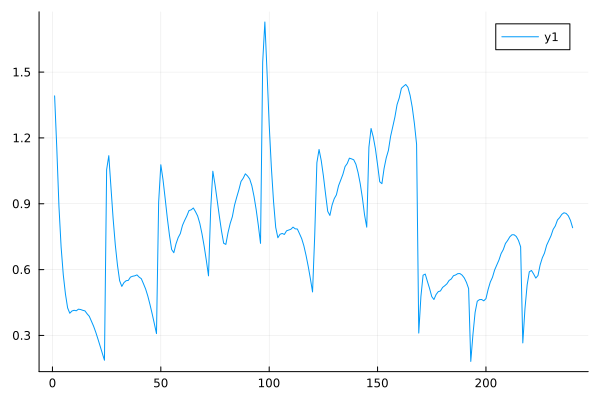

In [71]:
using Plots
plot(abs.(diag(cov_tot) .- diag(C_mod)) ./ diag(cov_tot))

In [72]:
npzwrite("../data/DESY1/binned_40_nzs/wlwl_cov_marg.npz",
        Dict("TPT0" => TT0, "TPT1" => TT1,
             "TPT2" => TT2, "TPT3" => TT3,
             "cov_marg" => C_mod,
             "inv_cov_marg" => inv_C_mod))

## T-Matrices gcgc

In [66]:
#println("My id is ", myid(), " and I have ", Threads.nthreads(), " threads")

fol = "DESY1"
data_set = "gcgc_Nzs_40"
meta = np.load(string("../../data/", fol, "/", data_set, "_meta.npz"))
files = npzread(string("../../data/", fol, "/", data_set, "_files.npz"))

tracers_names = pyconvert(Vector{String}, meta["tracers"])
pairs = pyconvert(Vector{Vector{String}}, meta["pairs"]);
idx = pyconvert(Vector{Int}, meta["idx"])
data_vector = pyconvert(Vector{Float64}, meta["cls"])
cov_tot = pyconvert(Matrix{Float64}, meta["cov"])
inv_cov_tot = pyconvert(Matrix{Float64}, meta["inv_cov"])

nz_path = "../../data/DESY1/binned_40_nzs/"
zs_k0, nz_k0, cov_k0 = get_nzs(nz_path, "DESgc__0_0")
zs_k1, nz_k1, cov_k1 = get_nzs(nz_path, "DESgc__1_0")
zs_k2, nz_k2, cov_k2 = get_nzs(nz_path, "DESgc__2_0")
zs_k3, nz_k3, cov_k3 = get_nzs(nz_path, "DESgc__3_0")

(Float32[0.06, 0.099999994, 0.14, 0.18, 0.22, 0.26, 0.3, 0.34, 0.38, 0.42000002  …  1.26, 1.3, 1.34, 1.38, 1.4200001, 1.46, 1.5, 1.54, 1.5799999, 1.62], [0.0009240673730447433, 0.005814852428634714, 0.0043443927624754715, 0.0041160596873804104, 0.009895392517209878, 0.003943404553941104, 0.005722829819267932, 0.0033400048064060497, 0.007211179232808158, 0.0031238118244838213  …  0.031763332972974484, 0.00911825258939116, 0.011404821613995498, 0.014876208760203333, 0.013381480231233972, 0.01378891718945615, 0.007705600228305088, 0.0036701150619442577, 0.0035936918557433503, 0.003960094429040499], [1.3836301678444849e-6 -1.3977640396582891e-8 … -1.395804086718494e-10 1.0317296311408265e-9; -1.3977640396582891e-8 2.103089987389617e-5 … -3.98300461516264e-9 -3.6854268751077994e-9; … ; -1.395804086718494e-10 -3.98300461516264e-9 … 3.774187479133305e-6 3.6353211990832475e-9; 1.0317296311408265e-9 -3.6854268751077994e-9 … 3.6353211990832475e-9 4.229474497801167e-6])

In [67]:
function model_cov0(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.24, 0.04, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("DESgc__0_0_nz" => x,
                     "DESgc__1_0_nz" => nz_k1,
                     "DESgc__2_0_nz" => nz_k2,
                     "DESgc__3_0_nz" => nz_k3,
                     "DESgc__0_0_b" => 1.21,
                     "DESgc__1_0_b" => 1.30,
                     "DESgc__2_0_b" => 1.48,
                     "DESgc__3_0_b" => 1.64)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov1(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.24, 0.04, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("DESgc__0_0_nz" => nz_k0,
                     "DESgc__1_0_nz" => x,
                     "DESgc__2_0_nz" => nz_k2,
                     "DESgc__3_0_nz" => nz_k3,
                     "DESgc__0_0_b" => 1.21,
                     "DESgc__1_0_b" => 1.30,
                     "DESgc__2_0_b" => 1.48,
                     "DESgc__3_0_b" => 1.64)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov2(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.24, 0.04, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("DESgc__0_0_nz" => nz_k0,
                     "DESgc__1_0_nz" => nz_k1,
                     "DESgc__2_0_nz" => x,
                     "DESgc__3_0_nz" => nz_k3,
                     "DESgc__0_0_b" => 1.21,
                     "DESgc__1_0_b" => 1.30,
                     "DESgc__2_0_b" => 1.48,
                     "DESgc__3_0_b" => 1.64)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov3(x;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.24, 0.04, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("DESgc__0_0_nz" => nz_k0,
                     "DESgc__1_0_nz" => nz_k1,
                     "DESgc__2_0_nz" => nz_k2,
                     "DESgc__3_0_nz" => x,
                     "DESgc__0_0_b" => 1.21,
                     "DESgc__1_0_b" => 1.30,
                     "DESgc__2_0_b" => 1.48,
                     "DESgc__3_0_b" => 1.64)
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;

In [68]:
d = 0.00000005
n_cls = 43
m  = length(nz_k0)
println(m)
T0 = zeros(n_cls, m)
T1 = zeros(n_cls, m)
T2 = zeros(n_cls, m)
T3 = zeros(n_cls, m)

for i in 1:m
    e = zeros(m)
    e[i] = d
    T0[:, i] = (model_cov0(nz_k0.+e) .- model_cov0(nz_k0.-e)) ./ (2*d)
    T1[:, i] = (model_cov1(nz_k1.+e) .- model_cov1(nz_k1.-e)) ./ (2*d)
    T2[:, i] = (model_cov2(nz_k2.+e) .- model_cov2(nz_k2.-e)) ./ (2*d)
    T3[:, i] = (model_cov3(nz_k3.+e) .- model_cov3(nz_k3.-e)) ./ (2*d)
end

40


In [58]:
#T0 = ForwardDiff.jacobian(model_cov0, nz_k0)
#T1 = ForwardDiff.jacobian(model_cov1, nz_k1)
#T2 = ForwardDiff.jacobian(model_cov2, nz_k2)
#T3 = ForwardDiff.jacobian(model_cov3, nz_k3)

In [69]:
TT0 = T0 * cov_k0 * T0'
TT1 = T1 * cov_k1 * T1'
TT2 = T2 * cov_k2 * T2'
TT3 = T3 * cov_k3 * T3';

In [70]:
C_mod = Symmetric(cov_tot + TT0 + TT1 + TT2 + TT3);
inv_C_mod = inv(C_mod)

43×43 Symmetric{Float64, Matrix{Float64}}:
    3.06311e8      3.20703e8  …   1920.55         2214.47
    3.20703e8      4.44584e9     11009.5         12712.5
    4.98689e7      1.61536e9     24933.1         28884.7
    7.58182e7      7.86935e6     38203.3         44158.5
    2.79941e7     -1.44844e8     42519.0         49467.0
   -1.02483e7     -4.31602e8  …  44984.1         52070.9
   -4.95083e7     -6.33118e8     32689.2         37835.5
   -7.51248e6     -4.90961e6        -3.38263e5      -3.90197e5
   -5.0528e6      -7.37394e7        -1.57397e6      -1.81807e6
   -3.83997e5     -2.1377e7         -3.51952e6      -4.07687e6
   -4.33401e5      1.94963e6  …     -6.28903e6      -7.2714e6
    4.08392e5      4.52968e6        -8.58459e6      -9.979e6
    1.15534e6      8.70558e6        -1.11094e7      -1.28597e7
    ⋮                         ⋱                  
  113.019      -3258.74             -3.58838e10     -4.23627e10
  266.205       2073.77             -6.20847e10     -7.25936e10
  56

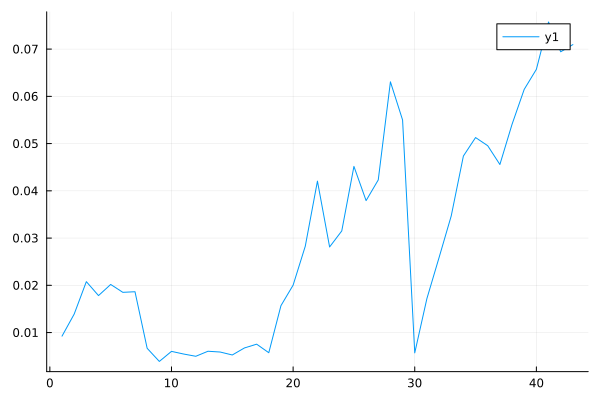

In [71]:
using Plots
plot(abs.(diag(cov_tot) .- diag(C_mod)) ./ diag(cov_tot))

In [9]:
npzwrite("../data/DESY1/binned_40_nzs/gcgc_cov_marg_lsst.npz",
        Dict("TPT0" => TT0, "TPT1" => TT1,
             "TPT2" => TT2, "TPT3" => TT3,
             "cov_marg" => C_mod,
             "inv_cov_marg" => inv_C_mod))

LoadError: SystemError: opening file "../data/DESY1/binned_40_nzs/gcgc_cov_marg_lsst.npz": No such file or directory

## Likelihood

In [86]:
#println("My id is ", myid(), " and I have ", Threads.nthreads(), " threads")

fol = "DESY1"
data_set = "gcgc"
meta = np.load(string("../../data/", fol, "/", data_set, "_meta.npz"))
files = npzread(string("../../data/", fol, "/", data_set, "_files.npz"))

tracers_names = pyconvert(Vector{String}, meta["tracers"])
pairs = pyconvert(Vector{Vector{String}}, meta["pairs"]);
idx = pyconvert(Vector{Int}, meta["idx"])
data_vector = pyconvert(Vector{Float64}, meta["cls"])
cov_tot = pyconvert(Matrix{Float64}, meta["cov"])
inv_cov_tot = pyconvert(Matrix{Float64}, meta["inv_cov"])

43×43 Matrix{Float64}:
    3.12725e8      3.5017e8   …      38.7265          40.0146
    3.5017e8       4.5879e9         219.165          227.781
    1.12753e8      1.93957e9        428.731          470.292
    1.7823e8       5.32695e8        597.887          704.324
    1.80903e8      6.39765e8        532.125          677.585
    1.91382e8      5.85085e8  …     375.817          533.421
    1.81429e8      5.16086e8        214.177          359.858
   -7.72113e6     -5.74599e6      -5831.4          -6057.16
   -5.69607e6     -7.66018e7     -27370.0         -28598.0
   -1.54025e6     -2.69239e7     -52505.5         -57961.5
   -2.08197e6     -6.21575e6  …  -85178.0             -1.00775e5
   -1.83325e6     -6.505e6       -88795.0             -1.13787e5
   -1.78052e6     -5.40686e6     -74067.7             -1.06232e5
    ⋮                         ⋱                   
 -314.784      -5450.54               5.38359e9        5.58754e9
 -331.887      -1032.19               7.49905e9        8.111

In [87]:
pars = [4.426868e-02,     2.093138e-01,     8.963611e-01,     8.495440e-01,
         1.343888e+00,    1.639047e+00,      1.597174e+00,     1.944583e+00,     2.007245e+00,
        -4.679383e-03,   -2.839996e-03,      1.771571e-03,     1.197051e-03,    -5.199799e-03,
         2.389208e-01,   -6.435288e-01, 
         1.802722e-03,   -5.508994e-03,     1.952514e-02,    -1.117726e-03,
        -1.744083e-02,    6.777779e-03,    -1.097939e-03,    -4.912315e-03,
         8.536883e-01,    2.535825e-01];

In [88]:
function get_cls(Ωm, s8;
               tracers_names=tracers_names,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    Ωb = pars[1]
    h = pars[4]
    ns = pars[3]

    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    DESgc__0_0_b = 1.21
    DESgc__1_0_b = 1.30
    DESgc__2_0_b = 1.48
    DESgc__3_0_b = 1.64

    nuisances = Dict("DESgc__0_0_b" => DESgc__0_0_b,
                     "DESgc__1_0_b" => DESgc__1_0_b,
                     "DESgc__2_0_b" => DESgc__2_0_b,
                     "DESgc__3_0_b" => DESgc__3_0_b)
    
    
    return Theory(cosmology, tracers_names, pairs,
                  idx, files; Nuisances=nuisances)
end;


In [89]:
function get_Xi2(Ωm, s8;
                 tk_mode="EisHu",
                 data_vector=data_vector,
                 inv_cov=inv_cov_tot)

    DESgc__0_0_b = 1.21
    DESgc__1_0_b = 1.30
    DESgc__2_0_b = 1.48
    DESgc__3_0_b = 1.64

    nuisances = Dict("DESgc__0_0_b" => DESgc__0_0_b,
                     "DESgc__1_0_b" => DESgc__1_0_b,
                     "DESgc__2_0_b" => DESgc__2_0_b,
                     "DESgc__3_0_b" => DESgc__3_0_b)
    

    Ωb = 0.04
    h = 0.67
    ns = 0.96
    
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode=tk_mode,
                                     Pk_mode="Halofit")
    
    theory = Theory(cosmology, tracers_names, pairs,
                    idx, files; Nuisances=nuisances)
    
    diff = @.(theory-data_vector)
    return dot(diff, inv_cov * diff)

end

get_Xi2 (generic function with 1 method)

In [90]:
Ωms = LinRange(0.1, 0.6, 30)
s8s = LinRange(0.6, 0.9, 30)

30-element LinRange{Float64, Int64}:
 0.6,0.610345,0.62069,0.631034,0.641379,…,0.868966,0.87931,0.889655,0.9

In [94]:
get_Xi2(0.24, 0.8)

778.1197776276722

In [92]:
Xi2s_EisHu = zeros(length(Ωms), length(s8s))
for i in 1:length(Ωms)
    for j in 1:length(s8s)
        Xi2s_EisHu[i, j] = get_Xi2(Ωms[i], s8s[j]; tk_mode="EisHu")
    end
end

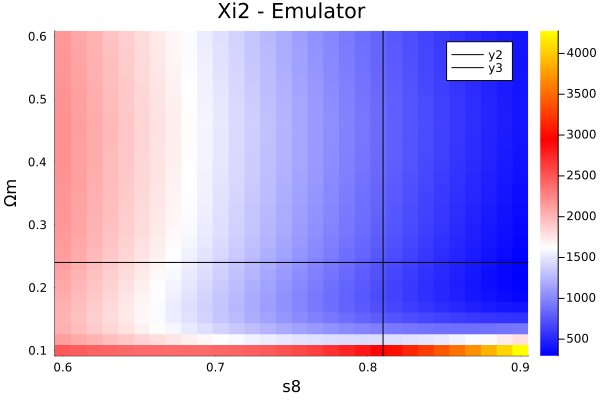

In [93]:
using Plots
gr()
heatmap(s8s, Ωms, Xi2s_EisHu,
    c=cgrad([:blue, :white,:red, :yellow]),
    ylabel="Ωm", xlabel="s8",
    title="Xi2 - Emulator")
vline!([0.81], c=:black)
hline!([0.24], c=:black)

In [55]:
n_samples = 100
cls = zeros(240, n_samples)
for i in 1:n_samples
    Ωm = rand(Uniform(0.2, 0.6))
    s8 = rand(Uniform(0.6, 0.9))
    cls[:, i] = get_cls(Ωm, s8)
end

LoadError: DimensionMismatch("tried to assign 43-element array to 240×1 destination")

In [70]:
npzwrite("Nz_cls_lsst.npz", Dict("cls" => cls))

## Turing

In [46]:
chain = sample(model(fake_data), NUTS(adaptation, TAP, ),
               MCMCDistributed(), iterations, nchains, progress=true; save_state=true)

LoadError: UndefVarError: fake_data not defined